# Projet 5 : Segmentez des clients d'un site e-commerce


**Problématique** :
- Olist souhaite que nous fournissions à ses équipes d'e-commerce une segmentation des clients qu'elles pourront utiliser au quotidien pour leurs campagnes de communication. L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles.
<br>
<br>
- Missions :
> Nous devrons fournir à l'équipe Marketing une description actionable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu'une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

# <a name="C0">Partie I. Analyse exploratoire des données<a>

**Importation des modules python**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Jeux de données**

In [2]:
# Loading all the nine datasets
customers = pd.read_csv("customers.csv",index_col=0)
geoloc = pd.read_csv("geoloc.csv",encoding="ISO-8859-1",index_col=0)
order_items = pd.read_csv("order_items.csv",index_col=0)
order_pymts = pd.read_csv("order_pymts.csv",index_col=0)
order_reviews = pd.read_csv("order_reviews.csv",encoding="ISO-8859-1", lineterminator='\n',index_col=0)
orders = pd.read_csv("orders.csv",index_col=0)
products = pd.read_csv("products.csv",index_col=0)
sellers = pd.read_csv("sellers.csv",encoding="ISO-8859-1",index_col=0)
translation = pd.read_csv("translation.csv",index_col=0)

In [3]:
# The shapes of the datasets
liste_dfs = [customers, geoloc, order_items, order_pymts,order_reviews, orders, products, sellers,translation]


names_dfs = ['customers','geolocalisation','order_items','order_payments','order_reviews','orders','products','sellers',
                                               'translation']

for df,df_name in zip(liste_dfs,names_dfs) :
    print(f"le jeux de données {df_name} est de dimension {df.shape}")
    print("-"*50)

le jeux de données customers est de dimension (99441, 5)
--------------------------------------------------
le jeux de données geolocalisation est de dimension (1000163, 5)
--------------------------------------------------
le jeux de données order_items est de dimension (112650, 7)
--------------------------------------------------
le jeux de données order_payments est de dimension (103886, 5)
--------------------------------------------------
le jeux de données order_reviews est de dimension (99231, 7)
--------------------------------------------------
le jeux de données orders est de dimension (99441, 8)
--------------------------------------------------
le jeux de données products est de dimension (32951, 9)
--------------------------------------------------
le jeux de données sellers est de dimension (3095, 4)
--------------------------------------------------
le jeux de données translation est de dimension (71, 2)
--------------------------------------------------


**Valeurs manquantes**

In [4]:
# Rate of NA values for all features
for df,df_name in zip(liste_dfs,names_dfs):
    print(f"""Taux de valeurs manquantes du jeu de données {df_name} :\n
            {(df.
                isnull().
                mean(axis=0)*100).
                reset_index().
                rename(columns={"index": "colonnes", 0: "NA_rate"})} """)
    print("-"*50)

Taux de valeurs manquantes du jeu de données customers :

                               colonnes  NA_rate
0               customer_id      0.0
1        customer_unique_id      0.0
2  customer_zip_code_prefix      0.0
3             customer_city      0.0
4            customer_state      0.0 
--------------------------------------------------
Taux de valeurs manquantes du jeu de données geolocalisation :

                                  colonnes  NA_rate
0  geolocation_zip_code_prefix      0.0
1              geolocation_lat      0.0
2              geolocation_lng      0.0
3             geolocation_city      0.0
4            geolocation_state      0.0 
--------------------------------------------------
Taux de valeurs manquantes du jeu de données order_items :

                          colonnes  NA_rate
0             order_id      0.0
1        order_item_id      0.0
2           product_id      0.0
3            seller_id      0.0
4  shipping_limit_date      0.0
5                price  

**1. Jeu de données Orders des commandes**

In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
index,,,,,,,,
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.8+ MB


- Ce dataset contient des infos sur les commandes passées sur le site de Olist.

In [7]:
# Convert date columns to date

orders["order_purchase_timestamp"] = pd.to_datetime(orders['order_purchase_timestamp'],format="%Y-%m-%d %H:%M:%S")
orders["order_approved_at"] = pd.to_datetime(orders['order_approved_at'],format="%Y-%m-%d %H:%M:%S")
orders["order_delivered_carrier_date"] = pd.to_datetime(orders['order_delivered_carrier_date'],format="%Y-%m-%d %H:%M:%S")
orders["order_delivered_customer_date"] = pd.to_datetime(orders['order_delivered_customer_date'],format="%Y-%m-%d %H:%M:%S")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders['order_estimated_delivery_date'],format="%Y-%m-%d %H:%M:%S")

orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.8+ MB


In [8]:
orders.order_status.value_counts().reset_index().rename(columns={"index":"order_status","order_status":"nb_orders"})

,order_status,nb_orders
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


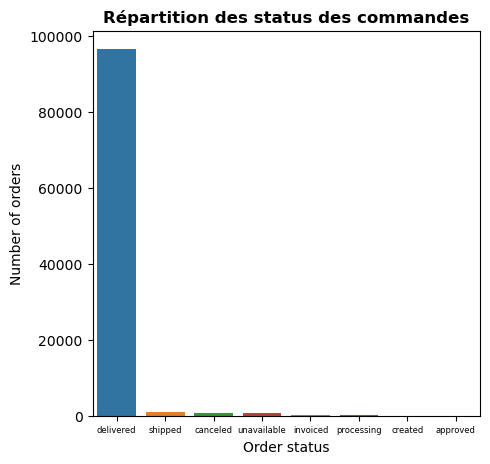

In [9]:
order_status_df = ( orders.
                  order_status.
                  value_counts().
                  reset_index().
                  rename(columns={"index":"order_status",
                                  "order_status":"nb_orders"})

)
plt.figure(figsize=(5,5))
sns.barplot(x='order_status', y='nb_orders', data=order_status_df)
plt.title("Répartition des status des commandes",fontweight="bold")
plt.xlabel("Order status")
plt.xticks(fontsize=6)
plt.ylabel("Number of orders")
plt.show()

- **Quasiment toutes les commandes sont livrées aux clients.**

**2. Jeu de données Customers**

In [11]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
index,,,,,
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.6+ MB


Ce dataset contient des informations sur le client. 
- Il permet d'identifier les clients("customer_id") dans le jeu de données des commandes et de trouver le lieu de livraison des commandes("customer_zip_code_prefix","customer_city" et "customer_state").

In [14]:
# Number of customers
customers.customer_id.nunique()

99441

In [13]:
# Number of unique customers
customers.customer_unique_id.nunique()

96096

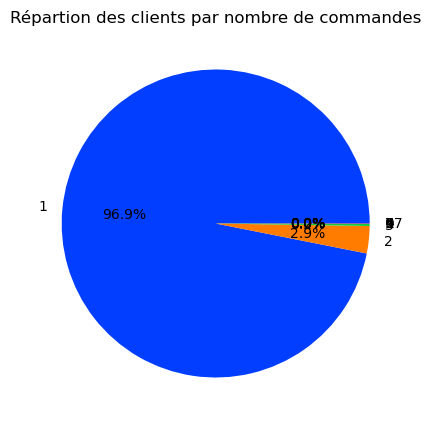

In [15]:
orders_per_customer = (customers
                                .groupby('customer_unique_id')
                                .size()
                                .value_counts().reset_index()
                                .rename(columns={"index":"nb_commands",0:"nb_customers"})
)

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

# create pie chart
plt.figure(figsize=(5,5))
plt.pie(orders_per_customer.nb_customers,labels=orders_per_customer.nb_commands.unique().tolist(),
        autopct='%1.1f%%',colors = colors)
plt.title('Répartion des clients par nombre de commandes')
plt.show() 

- **Environ 97% des clients n'ont commandé qu'une seule fois, moins de 3% de clients ont commandé 2 fois et le nombre de clients ayant commandé plus de 2 fois est inférieur à 1%.**

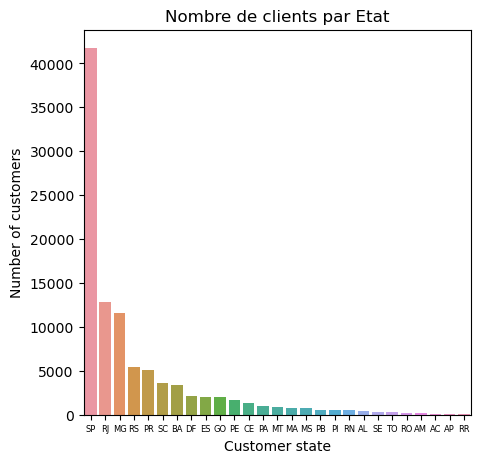

In [16]:
customer_state = ( customers
                        .groupby('customer_state')['customer_id']
                        .count()
                        .reset_index()
                        .rename(columns={"customer_id":"nb_customers"})
                        .sort_values(by='nb_customers', ascending=False)

)
plt.figure(figsize=(5,5))
sns.barplot(x='customer_state', y='nb_customers', data=customer_state)
plt.title("Nombre de clients par Etat")
plt.xlabel('Customer state')
plt.xticks(fontsize=6)
plt.ylabel('Number of customers')
plt.show()

- SP(Sao Paulo) est l'état où se trouve l'écrasante majorité des clients.
- Les états RJ(Rio de Janeiro) et MG(Minais Gerais) ont aussi beaucoup de clients.
- En revanche, les états RS (Rio Grande do Sul), PR (Paraná),SC (Santa Catarina) et BA (Bahia) ont peu de client mais le nombre de clients dans ces régions reste tout de même intéressant.

**3. Jeu de données Géolocalisation**

In [17]:
geoloc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
index,,,,,
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [18]:
geoloc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 45.8+ MB


Le dataset de géolocalisation fournit la ville, l'état, la latitude et la longitude correspondant aux codes postaux du Brésil.

**4. Jeu de données des Vendeurs**

In [19]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
index,,,,
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [20]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 120.9+ KB


L'ensemble de données des vendeurs fournit des informations sur leurs localisations ("seller_zip_code_prefix","seller_city","seller_state").

In [21]:
print(f"Nombre de vendeurs uniques: {sellers.seller_id.nunique()}")

Nombre de vendeurs uniques: 3095


**5. Jeu de données Order items**

In [22]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
index,,,,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.9+ MB


- Le jeu de données contient des informations sur les articles commandés(id vendeur, prix, date limite d'éxpedition etc...)

In [24]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [25]:
# Convert date columns to date
order_items["shipping_limit_date"] = pd.to_datetime(order_items['shipping_limit_date'],format="%Y-%m-%d %H:%M:%S")
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.9+ MB


**6. Jeu de données Order Pymnt des payements**

In [26]:
order_pymts.sample(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
index,,,,,
71019,f52f1f17c2bea20943049ec6a170f751,1,credit_card,4,115.81
50129,792aa3f0da2e24c9df178369950f2d13,1,credit_card,1,87.71
96724,dec147b0fad4d41a208b7873dd7900e6,1,boleto,1,31.69
253,f6ed483455295c6e7544f141244cd981,1,credit_card,2,151.51
28496,767f188a65e841e610f8a69e129fbdea,1,credit_card,1,55.00


Observation:
Le fichier de données liée aux paiements (df_payments) comporte trois variables importantes :

- payment_sequential qui indique si plusieurs méthodes de paiement sont appliquées, une ligne est crée par moyen de paiement utulisé
- payment_type mentionne le type de paiement effectué lors de la commende
- payment_installments représente le nombre de versements choisis.

Ce jeu de données donne des informations sur les options de paiement des commandes.

In [27]:
order_pymts.payment_type.unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [28]:
order_pymts.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [29]:
type_payments = (order_pymts.
                            groupby("payment_type")["order_id"].
                            count().reset_index().
                            rename(columns={"order_id":"nb_orders"}))
type_payments["percentage"] = round((type_payments["nb_orders"]*100)/type_payments["nb_orders"].sum(), 3)
type_payments.sort_values("percentage",ascending=False)

,payment_type,nb_orders,percentage
1,credit_card,76795,73.922
0,boleto,19784,19.044
4,voucher,5775,5.559
2,debit_card,1529,1.472
3,not_defined,3,0.003


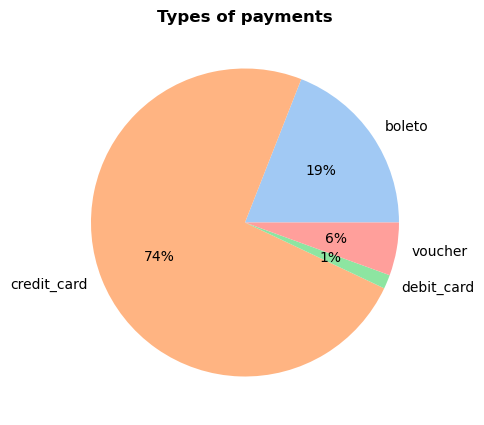

In [30]:
# Distribution of different types of payments

plt.figure(figsize=(5, 5))

# define Seaborn color palette to use
colors = sns.color_palette('pastel')

# Pie chart
plt.pie(type_payments.loc[type_payments.payment_type!="not_defined"].percentage,
        labels=type_payments.loc[type_payments.payment_type!="not_defined"].payment_type.unique().tolist(), 
        colors = colors, autopct='%.0f%%')

plt.title("Types of payments", fontweight='bold')
plt.show()

- La majorité des payments se font par carte de crédit.

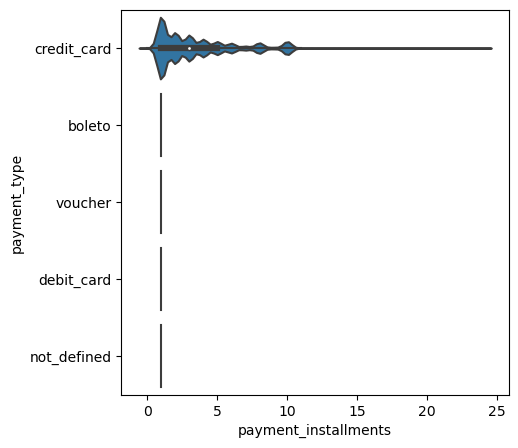

In [31]:
# Violinplot des paiements en plusieurs fois
plt.figure(figsize=(5,5))
sns.violinplot(data=order_pymts,x="payment_installments", y="payment_type",bins=10)
plt.show()

- Le seul type de payement avec lequel il y a des paiements en plusieurs fois est le payment en carte de crédit.
- Dans ces payments en carte de crédit, la majorité se fait en 1 seule fois, mais il y en a beaucoup qui s'échelonnent de 2,3,4 jusqu'à 10 fois.

**7. Jeu de données order_reviews des avis sur les commandes**

In [32]:
order_reviews.sample(8)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp\r
index,,,,,,,
27596,d782cb0ae5ee51ff3c1aee13ca014c6f,3744be9febaa00625c2791f629fb2ec8,5.0,Otimo,Rápido e produto de boa qualidade.,2018-05-12 00:00:00,2018-05-15 14:18:55\r
4945,2ce1e32e66c5f5c18650e93d34c91a11,6718a9b577ce4d3dfbdbdc7d3ec97cb6,5.0,NaN,Adorei este produto veio certinho e muito fáci...,2018-03-27 00:00:00,2018-04-03 13:57:46\r
9992,c210b4ed36c4ce629a8ce851be0d5828,de1c6db658e84e0ba847b2c1bc857bb5,1.0,NaN,Não veio o que foi pedido!!,2018-04-17 00:00:00,2018-04-17 22:55:46\r
68774,989b3adeb16fbef0670c532ee1fe0bc4,31437ad84ad2f4fd755bc1a5351d370d,4.0,NaN,NaN,2018-03-10 00:00:00,2018-03-13 12:08:42\r
96845,18395e784d05efa1db6c6de2dfb5697c,e1a9f566dc38eac4f78556976596a43f,5.0,NaN,Adoreiii,2018-07-07 00:00:00,2018-07-09 16:38:18\r
40685,633ed380e160d93bc5d70d763725eccb,c5aaa563ef4b0fd289de861d637f5a37,5.0,NaN,NaN,2018-02-21 00:00:00,2018-02-22 00:28:09\r
38314,02c383fe07ef2cf9cfc6614a3ab5a540,93a21c10557cc1b1ecfe2c3a808c648a,5.0,NaN,NaN,2018-03-06 00:00:00,2018-03-07 00:10:34\r
20630,233f8693e01661f5109e5fc38d2b87e8,f4309c5ccc24874aba5de216dc1616f0,5.0,NaN,NaN,2018-01-26 00:00:00,2018-01-27 09:57:41\r


In [33]:
# Convert date columns to date

order_reviews["review_creation_date"] = pd.to_datetime(order_reviews["review_creation_date"],format="%Y-%m-%d %H:%M:%S")
order_reviews["review_answer_timestamp\r"] = pd.to_datetime(order_reviews["review_answer_timestamp\r"],
                                                            format="%Y-%m-%d %H:%M:%S")
# Rename review_answer_timestamp columnn
order_reviews.rename(columns={"review_answer_timestamp\r":"review_answer_timestamp"},inplace=True)
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99231 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99231 non-null  object        
 1   order_id                 99231 non-null  object        
 2   review_score             99224 non-null  float64       
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99217 non-null  datetime64[ns]
 6   review_answer_timestamp  99217 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 6.1+ MB


- Ce jeu de données donne des informations sur les avis des clients sur les commandes qu'ils ont effectuées.

In [34]:
print(f"La moyenne des notes sur les commandes est de : {round(order_reviews.review_score.mean(),2)}.")

La moyenne des notes sur les commandes est de : 4.09.


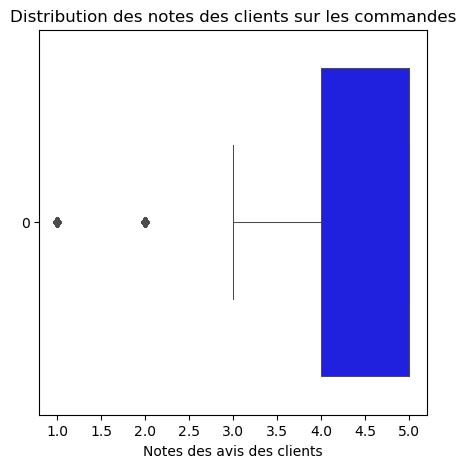

In [35]:
# Boxplot des notes des clients sur les commandes

plt.figure(figsize=(5,5))
sns.boxplot(order_reviews["review_score"],orient="h",color="b", linewidth=.75)
plt.title("Distribution des notes des clients sur les commandes")
plt.xlabel("Notes des avis des clients")

plt.show()

- Généralement les commandes sont bien notées.

**8. Jeu de données "products" des produits**

In [36]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
index,,,,,,,,,
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [37]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


- Ce jeu de données contient des informations sur les produits vendus sur le site d'Olist.

**9. Jeu de données "translation" de la traduction des noms de catégorie**

In [38]:
translation.head()

,product_category_name,product_category_name_english
index,,
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [39]:
translation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


- Ce jeu de données donne une traduction en anglais du nom de la catégorie des produits.

## Le jeu de données final

**Assembler les jeux de données**

- Nous allons d'abord joindre les tables "customers" et "orders" grâce à l'identifiant de clients "customer_id" que l'on retrouve comme clé étrangère dans la table des commandes "orders".

- L'identifiant des commandes "order_id" est une clé étrangère pour les tables "order_items","order_pymts" et "order_reviews":
    - Nous allons joindre notre table de la jointure précédente successivement à chacune de ces tables order_items,order_pymts et order_reviews.
- Enfin, nous allons merger la table "products" avec la table "translation" pour avoir la colonne de traduction en anglais des noms des catégories de produits grâce à leur colonne commune "product_category_name", puis nous allons joindre le resultat avec notre table précédente.

In [52]:
# merge customer & orders_data
df1 = pd.merge(customers, orders, on="customer_id")

# merge df1 & order_items
df2 = pd.merge(df1, order_items, on="order_id")

# merge df2 & order_pymts
df3 = pd.merge(df2, order_pymts, on="order_id")

# merge df3 & order_reviews
df4 = pd.merge(df3, order_reviews, on="order_id")

# merge products and translation datasets to get product categories translated to english
products_df = pd.merge(products,translation, on="product_category_name")

# final dataset 
customer_data = pd.merge(df4, products_df, on='product_id')
customer_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,2017-05-30 22:34:40,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,2017-05-28 02:43:16,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,2018-03-02 11:11:24,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27 23:04:18,2017-03-27 23:23:38,2017-03-28 14:18:59,...,2017-04-04 01:37:20,pet_shop,43.0,779.0,1.0,300.0,16.0,16.0,16.0,pet_shop
115605,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07 23:55:46,2017-12-09 23:50:32,2017-12-11 20:29:02,...,2018-01-07 14:33:35,beleza_saude,40.0,1694.0,1.0,2400.0,33.0,10.0,16.0,health_beauty
115606,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04 17:50:52,2018-04-04 18:08:41,2018-04-05 16:36:49,...,2018-04-11 13:34:08,fashion_bolsas_e_acessorios,29.0,498.0,4.0,300.0,16.0,16.0,11.0,fashion_bags_accessories
115607,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14 12:04:09,2017-11-14 12:15:25,2017-11-27 20:44:47,...,2017-12-16 13:50:11,eletronicos,33.0,63.0,1.0,6185.0,63.0,11.0,20.0,electronics


In [55]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115609 non-null  object        
 1   customer_unique_id             115609 non-null  object        
 2   customer_zip_code_prefix       115609 non-null  int64         
 3   customer_city                  115609 non-null  object        
 4   customer_state                 115609 non-null  object        
 5   order_id                       115609 non-null  object        
 6   order_status                   115609 non-null  object        
 7   order_purchase_timestamp       115609 non-null  datetime64[ns]
 8   order_approved_at              115595 non-null  datetime64[ns]
 9   order_delivered_carrier_date   114414 non-null  datetime64[ns]
 10  order_delivered_customer_date  113209 non-null  datetime64[ns]
 11  

In [63]:
# Which product categories is most ordered?
(customer_data.
    product_category_name_english.
    value_counts().
    reset_index().
    rename(columns={"index":"product_category_name_english",
                                  "product_category_name_english":"nb_orders"})
)

,product_category_name_english,nb_orders
0,bed_bath_table,11847
1,health_beauty,9944
2,sports_leisure,8942
3,furniture_decor,8743
4,computers_accessories,8105
...,...,...
66,arts_and_craftmanship,24
67,la_cuisine,15
68,cds_dvds_musicals,14
69,fashion_childrens_clothes,8


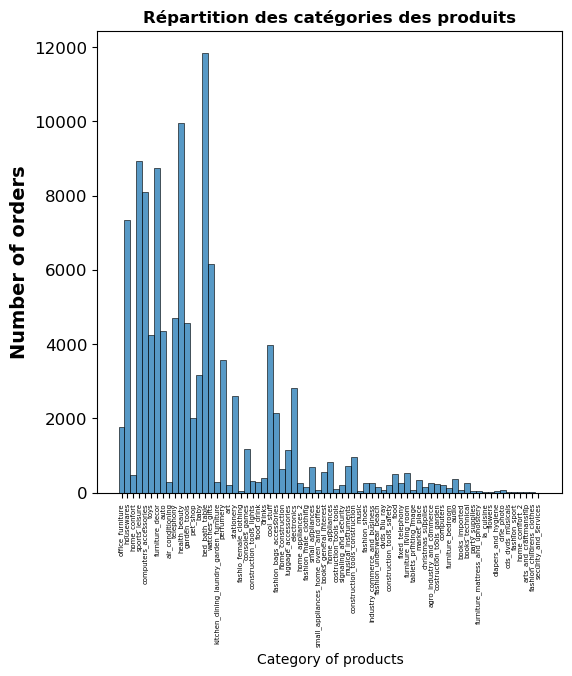

In [64]:
# Visualizing product categories repartition
plt.figure(figsize=(6,6))

sns.histplot(x="product_category_name_english",data= customer_data)

plt.title("Répartition des catégories des produits",fontweight="bold")
plt.ylabel('Number of orders', fontsize=14,fontweight="bold")
plt.xlabel('Category of products', fontsize=10)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=12)
plt.show()

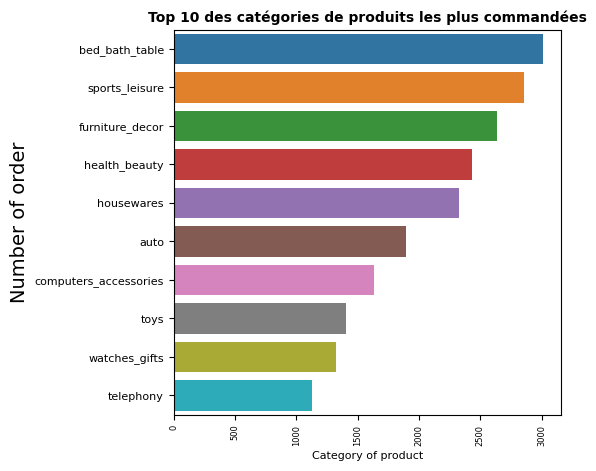

In [65]:
# Top 10 of most ordered categories 

products_top10 = customer_data.groupby(["product_id","product_category_name_english"]).count().reset_index()

# Countplot
plt.figure(figsize=(5, 5))
sns.countplot(y=products_top10.product_category_name_english,data=products_top10,
              order=products_top10.product_category_name_english.value_counts().head(10).index)

plt.title("Top 10 des catégories de produits les plus commandées", fontsize=10,fontweight="bold")
plt.ylabel("Number of order", fontsize=14)
plt.xlabel("Category of product", fontsize=8)
plt.xticks(rotation=90,fontsize=6)
plt.yticks(fontsize=8)
plt.show()

- Voici les dix catégories de produits les plus vendus.

In [66]:
customer_data[["price","freight_value","payment_value"]].sample(30)

,price,freight_value,payment_value
63912,79.00,23.11,149.42
9580,23.90,15.11,39.01
70569,39.90,18.23,58.13
40474,57.90,18.29,76.19
96915,29.99,12.79,20.05
24642,59.99,11.81,71.80
91483,429.99,99.56,42.31
23935,31.80,16.60,290.40
65536,11.00,7.87,37.74
46381,29.99,18.23,20.00


- **Derniers nettoyages du jeu de données**

In [75]:
# Droping unuseful features
customer = customer_data.copy()
customer = customer.drop(["seller_id","review_id","review_comment_title","review_comment_message",
                  "review_creation_date","review_answer_timestamp","order_delivered_customer_date","customer_id","product_id",
                  "product_category_name","shipping_limit_date","order_item_id","product_description_lenght",
                   "order_estimated_delivery_date","product_name_lenght","product_photos_qty",
                          "customer_zip_code_prefix","order_id","product_weight_g","payment_sequential",
                         "product_length_cm","product_height_cm","product_width_cm","payment_type",
                         "payment_installments"], axis=1)


# Making sure that price of item + freight value is equal to payment value
customer = customer.loc[(customer["price"]+customer["freight_value"]==customer["payment_value"])]

# Keeping only delivered orders
customer = customer[customer["order_status"]=="delivered"]

# Avoiding Order date > delivererd carrier date or Order date > approved date
customer = customer[~((customer['order_purchase_timestamp'].dt.date>customer['order_delivered_carrier_date'].dt.date)|
                      (customer['order_purchase_timestamp'].dt.date>customer['order_approved_at'].dt.date))]

# Droping unuseful columns
customer.drop(["order_status","price","freight_value","order_delivered_carrier_date","order_approved_at"],axis=1,inplace=True)

customer.reset_index(drop=True,inplace=True)
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67023 entries, 0 to 67022
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             67023 non-null  object        
 1   customer_city                  67023 non-null  object        
 2   customer_state                 67023 non-null  object        
 3   order_purchase_timestamp       67023 non-null  datetime64[ns]
 4   payment_value                  67023 non-null  float64       
 5   review_score                   67023 non-null  float64       
 6   product_category_name_english  67023 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 3.6+ MB


In [76]:
customer

,customer_unique_id,customer_city,customer_state,order_purchase_timestamp,payment_value,review_score,product_category_name_english
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,2017-05-16 15:05:35,146.87,4.0,office_furniture
1,f40ab89b622248b7ca125af4b486b887,contagem,MG,2017-05-16 10:00:49,155.70,4.0,office_furniture
2,432ecfa8b7b7ad2663c7abed0dc83c51,belo horizonte,MG,2018-03-15 07:45:10,150.07,3.0,office_furniture
3,67d6f91d256bdf128fc960a166f413d5,petropolis,RJ,2017-10-13 10:36:54,151.17,3.0,office_furniture
4,1c91f8d50340522dd6601237ad13afff,colider,MT,2018-02-07 19:01:48,160.18,4.0,office_furniture
...,...,...,...,...,...,...,...
67018,e097d846931763789c3fd00b27f3c325,sao paulo,SP,2017-03-20 18:33:07,51.64,5.0,furniture_decor
67019,fb354969e06f2093c0083cbfbb91864e,sao paulo,SP,2018-07-14 14:08:11,121.04,3.0,home_confort
67020,5f2971f9805e3ccb030226e30c8e8390,sao paulo,SP,2017-03-27 23:04:18,30.95,4.0,pet_shop
67021,c64ede6d0ae8901b1b6fb03528c1b7e6,sao miguel do guama,PA,2017-12-07 23:55:46,304.11,4.0,health_beauty


In [77]:
customer.product_category_name_english

0                office_furniture
1                office_furniture
2                office_furniture
3                office_furniture
4                office_furniture
                   ...           
67018             furniture_decor
67019                home_confort
67020                    pet_shop
67021               health_beauty
67022    fashion_bags_accessories
Name: product_category_name_english, Length: 67023, dtype: object

In [78]:
# Save the data for clustering segmentations
# customer.to_csv("clustering_data.csv")